In [28]:
import os
import pandas as pd
import cv2 as cv
import hashlib
import numpy as np
import matplotlib.pyplot as plt

import shutil

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, average_precision_score
from PIL import Image
import random

#PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader

print("torch.cuda.is_available():", torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
import sys
print(sys.executable)

torch.cuda.is_available(): True
cuda
C:\Users\mbebe\PycharmProjects\ZNEUS_test\.venv\Scripts\python.exe


In [29]:
df = pd.read_csv("archive/sports.csv")
df.head()

class id                 filepaths      labels data set
0         0  train/air hockey/001.jpg  air hockey    train
1         0  train/air hockey/002.jpg  air hockey    train
2         0  train/air hockey/003.jpg  air hockey    train
3         0  train/air hockey/004.jpg  air hockey    train
4         0  train/air hockey/005.jpg  air hockey    train

In [30]:
#Let's get rid of the spaces in labels right away
df.labels = df.labels.str.replace(' ', '_')
#Also, let's look at how many pictures of each sport do we have
df.labels.value_counts()

labels
football              201
formula_1_racing      200
nascar_racing         199
baseball              184
hockey                182
                     ... 
horseshoe_pitching    112
arm_wrestling         109
wingsuit_flying       108
ultimate              107
sky_surfing            69
Name: count, Length: 100, dtype: int64

In [31]:
#Since we have to classify 10 classes, I think the first 10 are good enough, since those are pretty distinct ones and also, they have nearly enough images
#(Lecturer said, that for classification task, there should be around 200-400 images per class)
#Also, I'm pretty sure it's supposed to be canoe slalom, not slamon, but my laziness is unimaginable, so I'm going to let it be.

In [32]:
Path_to_csv = "archive/"
size = 0
duplicate = 0
dictionary = {}

for img_path in df["filepaths"]:
    img_path = Path_to_csv + img_path
    img = cv.imread(img_path)

    #detecting format
    if img is None:
        print("Image {} not found".format(img_path))
        row_to_drop = df[df["filepaths"]==img_path].index
        df.drop(row_to_drop, inplace=True)
        continue

    #checking for duplicates
    hashed_image = hashlib.md5(img).hexdigest()
    if hashed_image not in dictionary:
        dictionary[hashed_image] = img_path
    else:
        duplicate += 1

    #checking size
    height, width = img.shape[:2]
    if height != width != 244:
        size += 1

print(f"Number of exact duplicates: {duplicate}")
print(f"Number of images with incorrect size: {size}")

Image archive/train/high jump/159.lnk not found
Number of exact duplicates: 0
Number of images with incorrect size: 0


In [33]:
#We can see, that there is a one image is not image at all, so we have to drop it.
#There are no exact duplicates in the dataset
#All images have correct size
df.labels.value_counts()

labels
football              201
formula_1_racing      200
nascar_racing         199
baseball              184
hockey                182
                     ... 
horseshoe_pitching    112
arm_wrestling         109
wingsuit_flying       108
ultimate              107
sky_surfing            69
Name: count, Length: 100, dtype: int64

In [34]:
#Now we will filter the dataset to classes we want to classify plus one unknown class, build from the other classes
#Unknow class size will be adjusted to match size of other classes

dataframe = df.copy()

selected = ["football", "formula_1_racing","nascar_racing","baseball","hockey","basketball","olympic_wrestling","rugby","canoe_slamon", "roller_derby"]

for index, label in dataframe['labels'].items():
    if label not in selected:
        dataframe.drop(index, inplace=True)

#We also need to update classes
dataframe.rename(columns={'class id': 'class_id'}, inplace=True)
dataframe["class_id"] = pd.Categorical(dataframe["labels"], categories=selected).codes
dataframe.head()

class_id               filepaths    labels data set
838         3  train/baseball/001.jpg  baseball    train
839         3  train/baseball/002.jpg  baseball    train
840         3  train/baseball/003.jpg  baseball    train
841         3  train/baseball/004.jpg  baseball    train
842         3  train/baseball/005.jpg  baseball    train

In [35]:
#at this point, we can drop the label and use one hot on class_id, which is basically our new label
reduced_dataframe = dataframe.copy()
reduced_dataframe.drop(["labels"], axis=1, inplace=True)
one_hot = pd.get_dummies(reduced_dataframe['class_id'])
reduced_dataframe = reduced_dataframe.drop(["class_id"], axis=1)
reduced_dataframe = one_hot.join(reduced_dataframe)
reduced_dataframe.head()

0      1      2     3      4      5      6      7      8      9  \
838  False  False  False  True  False  False  False  False  False  False   
839  False  False  False  True  False  False  False  False  False  False   
840  False  False  False  True  False  False  False  False  False  False   
841  False  False  False  True  False  False  False  False  False  False   
842  False  False  False  True  False  False  False  False  False  False   

                  filepaths data set  
838  train/baseball/001.jpg    train  
839  train/baseball/002.jpg    train  
840  train/baseball/003.jpg    train  
841  train/baseball/004.jpg    train  
842  train/baseball/005.jpg    train

In [36]:
#Now we need to split the data into train, test and validation datasets
#In this case we will try to use already prepared separation
#TODO -> if anyone will have time, we should split it by ourselves as well
test_data = reduced_dataframe[reduced_dataframe["data set"] == "test"]
test_data = test_data.drop(["data set"], axis=1)
train_data = reduced_dataframe[reduced_dataframe["data set"] == "train"]
train_data = train_data.drop(["data set"], axis=1)
validation_data = reduced_dataframe[reduced_dataframe["data set"] == "valid"]
validation_data = validation_data.drop(["data set"], axis=1)
#Now we have all the datasets split.

In [37]:
train_data.describe(include="all")

0      1      2      3      4      5      6      7      8      9  \
count    1745   1745   1745   1745   1745   1745   1745   1745   1745   1745   
unique      2      2      2      2      2      2      2      2      2      2   
top     False  False  False  False  False  False  False  False  False  False   
freq     1554   1555   1556   1571   1573   1576   1578   1579   1581   1582   

                  filepaths  
count                  1745  
unique                 1745  
top     train/rugby/166.jpg  
freq                      1

5 rows × 150540 columns

In [38]:
BASE = "archive/"
TARGET_SIZE = (224, 224)

#normalizovanie aj nenormalizovanie na porovnanie
def load_image_as_array_unnormalized(path, size=TARGET_SIZE):
    full_path = BASE + path
    try:
        img = Image.open(full_path).convert("RGB").resize(size)
        arr = np.asarray(img, dtype=np.float32)
        return arr
    except:
        return None

def load_image_as_array_normalized(path, size=TARGET_SIZE):
    full_path = BASE + path
    try:
        img = Image.open(full_path).convert("RGB").resize(size)
        arr = np.asarray(img, dtype=np.float32) / 255.0
        return arr
    except:
        return None

# --- Spustenie načítania dát (Vytvárame obe polia) ---

image_data_list_unnormalized = []
image_data_list_normalized = []
valid_indices = []

for idx, path in train_data["filepaths"].items():# vo for loope prechadzame vsetky riadky train_data "preformatuie" ich an NumPy arraye
    img_unnormalized = load_image_as_array_unnormalized(path)
    if img_unnormalized is not None:
        valid_indices.append(idx)
        image_data_list_unnormalized.append(img_unnormalized)

        #nacitame normalizovanu verziu len pre platne obrázky
        img_normalized = load_image_as_array_normalized(path)
        image_data_list_normalized.append(img_normalized)

#vytvorenie finalnych NumPy polí a ich naplnenie
X_train_unnormalized = np.array(image_data_list_unnormalized)
X_train_normalized = np.array(image_data_list_normalized)

print(f"Tvar nenormalizovaných dát: {X_train_unnormalized.shape}")
print(f"Tvar normalizovaných dát: {X_train_normalized.shape}")

Tvar nenormalizovaných dát: (1745, 224, 224, 3)
Tvar normalizovaných dát: (1745, 224, 224, 3)


In [39]:
print("## ️Analýza NumPy Polí")
print("-------------------------------------------------------")

#robime pre (X_train_unnormalized)

print("### Nenormalizované dáta (X_train_unnormalized)")
print(f"Tvar (Shape): {X_train_unnormalized.shape}")
print(f"Typ dát (Dtype): {X_train_unnormalized.dtype}")

# [0] -> prvý obrázok
# [0, 0] -> pixel v ľavom hornom rohu (riadok 0, stĺpec 0)
# [0, 0, :] -> všetky 3 RGB kanály
print("\nUkážka hodnôt pixelov (Prvý obrázok, ľavý horný roh):")
print(X_train_unnormalized[0, 0, 0:5]) # Vypíše prvých 5 hodnôt R, G, B...

#kontrola rozsahu hodnôt (musia vyt medzi 0 až 255)
print(f"\nMinimum hodnôt: {np.min(X_train_unnormalized):.2f}")
print(f"Maximum hodnôt: {np.max(X_train_unnormalized):.2f}")

print("-------------------------------------------------------")

#normalizované dáta (X_train_normalized)

print("### Normalizované dáta (X_train_normalized)")
print(f"Tvar (Shape): {X_train_normalized.shape}")
print(f"Typ dát (Dtype): {X_train_normalized.dtype}")

#ukážka hodnôt z prvého pixelu prvého obrázku (porovnanie)
print("\nUkážka hodnôt pixelov (Prvý obrázok, ľavý horný roh):")
print(X_train_normalized[0, 0, 0:5]) # Vypíše prvých 5 hodnôt R, G, B...

#kontrola rozsahu hodnôt (očakávame 0.0 až 1.0)
print(f"\nMinimum hodnôt: {np.min(X_train_normalized):.4f}")
print(f"Maximum hodnôt: {np.max(X_train_normalized):.4f}")


## ️Analýza NumPy Polí
-------------------------------------------------------
### Nenormalizované dáta (X_train_unnormalized)
Tvar (Shape): (1745, 224, 224, 3)
Typ dát (Dtype): float32

Ukážka hodnôt pixelov (Prvý obrázok, ľavý horný roh):
[[51. 56. 78.]
 [55. 60. 82.]
 [59. 64. 86.]
 [64. 69. 89.]
 [70. 77. 96.]]

Minimum hodnôt: 0.00
Maximum hodnôt: 255.00
-------------------------------------------------------
### Normalizované dáta (X_train_normalized)
Tvar (Shape): (1745, 224, 224, 3)
Typ dát (Dtype): float32

Ukážka hodnôt pixelov (Prvý obrázok, ľavý horný roh):
[[0.2        0.21960784 0.30588236]
 [0.21568628 0.23529412 0.32156864]
 [0.23137255 0.2509804  0.3372549 ]
 [0.2509804  0.27058825 0.34901962]
 [0.27450982 0.3019608  0.3764706 ]]

Minimum hodnôt: 0.0000
Maximum hodnôt: 1.0000


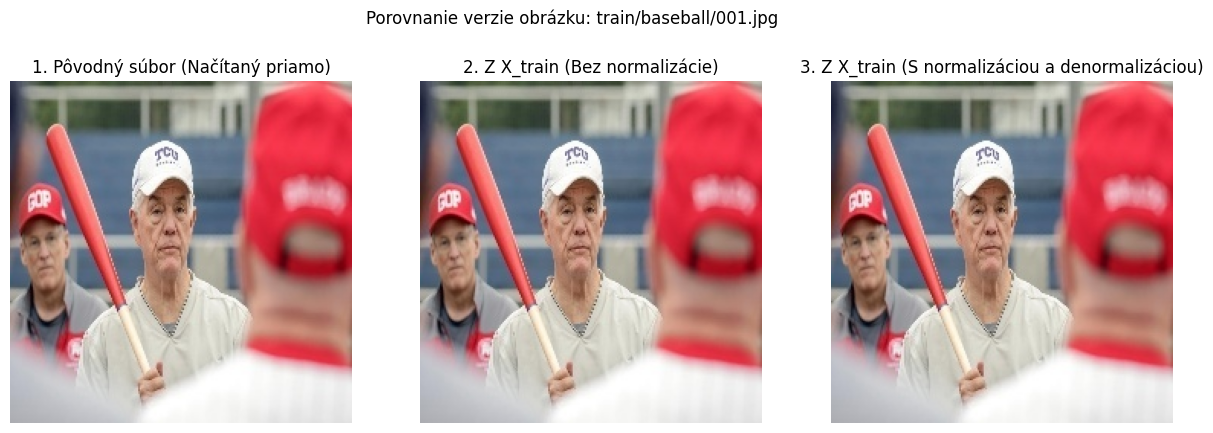

In [40]:
IMAGE_INDEX_TO_CHECK = 0
if len(X_train_unnormalized) == 0:
    print("Neboli načítané žiadne platné obrázky na porovnanie.")
else:
    original_df_index = valid_indices[IMAGE_INDEX_TO_CHECK]
    filepath_to_check = train_data.loc[original_df_index, "filepaths"]
    full_path_original = BASE + filepath_to_check

    #načítame pôvodný obrázok
    try:
        img_original_file = Image.open(full_path_original).convert("RGB").resize(TARGET_SIZE)
        img_original_file_array = np.asarray(img_original_file, dtype=np.uint8)

        #polia na zobrazenie a porovnanie
        #pole bez normalizácie (0-255 float -> uint8)
        img_unnormalized_array = X_train_unnormalized[IMAGE_INDEX_TO_CHECK].astype(np.uint8)
        #pole s normalizáciou (0-1 float -> denormalizácia -> uint8)
        img_normalized_denormalized_array = (X_train_normalized[IMAGE_INDEX_TO_CHECK] * 255).astype(np.uint8)

        #Vykreslenie všetkých troch obrázkov
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(img_original_file_array)
        axes[0].set_title("1. Pôvodný súbor (Načítaný priamo)")
        axes[0].axis('off')

        axes[1].imshow(img_unnormalized_array)
        axes[1].set_title("2. Z X_train (Bez normalizácie)")
        axes[1].axis('off')

        axes[2].imshow(img_normalized_denormalized_array)
        axes[2].set_title("3. Z X_train (S normalizáciou a denormalizáciou)")
        axes[2].axis('off')

        plt.suptitle(f"Porovnanie verzie obrázku: {filepath_to_check}")
        plt.show()
    except FileNotFoundError:
        print(f"Chyba: Súbor nenájdený na ceste: {full_path_original}. Skontroluj Base a subor")

Generovanie dokončené. Finálny tvar X_train: (1745, 224, 224, 3)


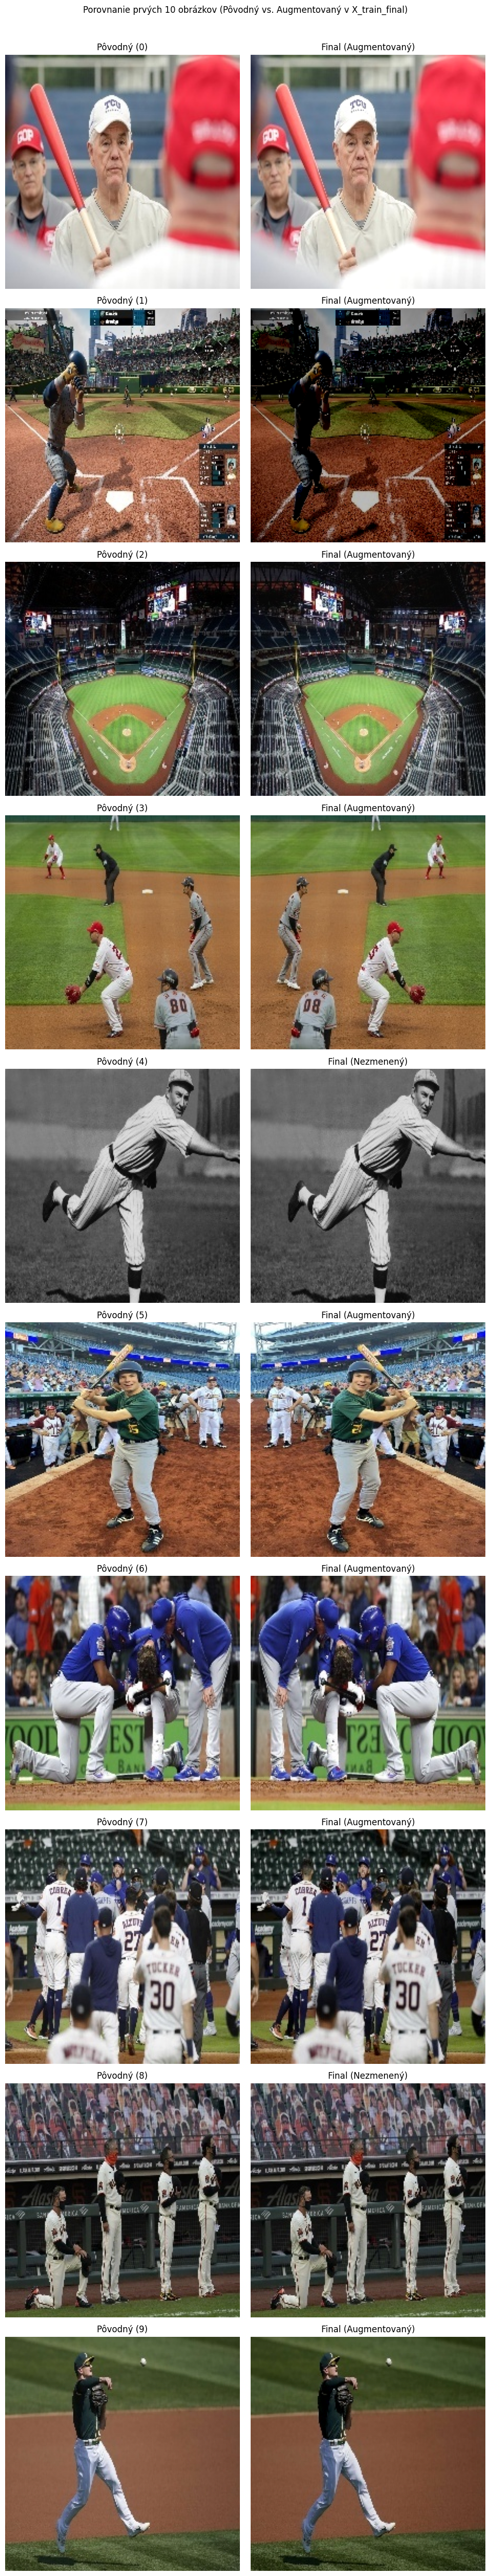

In [41]:
BRIGHTNESS_FACTOR = 0.4        #max rozsah jasu (napr. -0.4 až +0.4)
FLIP_PROBABILITY = 0.5
BRIGHTNESS_PROBABILITY = 0.5

def augment_image_for_training(image_array):
    #pouzijeme kopiu, aby sme neupravovali originál X_train_normalized
    augmented_image = image_array.copy()

    #zmena Jasu
    if random.random() < BRIGHTNESS_PROBABILITY:
        #nahodne vyberieme faktor jasu v rozsahu[-BRIGHTNESS_FACTOR, BRIGHTNESS_FACTOR]
        brightness_delta = random.uniform(-BRIGHTNESS_FACTOR, BRIGHTNESS_FACTOR)
        augmented_image += brightness_delta
        #orezanie hodnot spat do rozsahu 0-1
        augmented_image = np.clip(augmented_image, 0.0, 1.0)

    # preklopenie okolo Y
    if random.random() < FLIP_PROBABILITY:
        augmented_image = np.flip(augmented_image, axis=1)

    return augmented_image

X_train_final_list = []
#ideme cez vsetky obrazky v normalizovanej sade
for i in range(X_train_normalized.shape[0]):
    #sanca na augmentaciu
    final_image = augment_image_for_training(X_train_normalized[i])
    X_train_final_list.append(final_image)

#pretvorime na filane numpy pole
X_train_final = np.array(X_train_final_list)

print(f"Generovanie dokončené. Finálny tvar X_train: {X_train_final.shape}")

#vykreslenie
NUM_IMAGES_TO_SHOW = 10

fig, axes = plt.subplots(NUM_IMAGES_TO_SHOW, 2, figsize=(10, 5 * NUM_IMAGES_TO_SHOW))
plt.suptitle(f"Porovnanie prvých {NUM_IMAGES_TO_SHOW} obrázkov (Pôvodný vs. Augmentovaný v X_train_final)", y=1.005)

#10 obrazkov
for i in range(NUM_IMAGES_TO_SHOW):

    #povodný obrazok
    original_image = X_train_normalized[i]

    #obrazok z novej sady X_train_final
    final_image = X_train_final[i]

    #denormalizacia na 0-255 uint8 pre zobrazenie
    original_display = (original_image * 255).astype(np.uint8)
    final_display = (final_image * 255).astype(np.uint8)

    # Vykreslenie pôvodného
    axes[i, 0].imshow(original_display)
    axes[i, 0].set_title(f"Pôvodný ({i})")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(final_display)

    #info ci sa image zmenil
    if np.array_equal(original_image, final_image):
        title = f"Final (Nezmenený)"
    else:
        title = f"Final (Augmentovaný)"

    axes[i, 1].set_title(title)
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

---
Evaluation Matrics

Presnosť

Pomer správne klasifikovaných vzoriek k celkovému počtu vzoriek. Vhodná, ak sú všetky triedy dobre vyvážené (čo sme sa snažili dosiahnuť vyvážením "unknown" triedy).

Weighted F1-Score

Vhodna, ak sú triedy mierne nevyvážené alebo ak ti záleží na rovnomernom výkone vo všetkých triedach.

Presnosť (Precision) pre každú triedu

Z odpovedí pre danú triedu, koľko z nich bolo skutočne správnych. Ukazuje, ako často model robí falošne pozitívne predpovede pre túto triedu (napr. ako často označí "futbal" ako "neznámy").

Confusion Matrix

Nutna na zistenia ko moc sa model myli, porovnanie skutocne vysledko s ocakavanymi

In [42]:
normalization_mean = [0.5, 0.5, 0.5]
normalization_std = [0.5, 0.5, 0.5]
target_size = 224
batches = 256

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(TARGET_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.ToTensor(), # Converts image to a PyTorch Tensor
    transforms.Normalize(mean=normalization_mean, std=normalization_std)
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(TARGET_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=normalization_mean, std=normalization_std)
])

In [43]:
#Move to directory with custom classes
universal_input_path = "archive/"
universal_output_path = "custom_data/"

folders = ["test/", "train/", "valid/"]

for folder in folders:
    for cls in selected:
        try:
            os.mkdir(universal_output_path + folder + cls)
        except FileExistsError:
            pass
        shutil.copytree(universal_input_path + folder + cls.replace("_", " "), universal_output_path + folder + cls, dirs_exist_ok=True)


In [44]:
import os
from PIL import Image
import random
from torchvision import transforms

BASE_PATH = "custom_data/"
folders = ["train", "test", "valid"]

# ----------------------------
# Augmentations (rich & varied)
# ----------------------------
augmentations = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomRotation(25),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
        transforms.GaussianBlur(kernel_size=3),
    ]),
    transforms.Resize((224, 224)),
])

def augment_image(image_path):
    """Open image, create augmented copy, save next to original."""
    img = Image.open(image_path).convert("RGB")

    # Apply augmentation
    aug = augmentations(img)

    # New filename
    dir_path = os.path.dirname(image_path)
    base_name = os.path.basename(image_path)
    name_no_ext, ext = os.path.splitext(base_name)

    new_filename = f"{name_no_ext}_aug{ext}"
    new_path = os.path.join(dir_path, new_filename)

    aug.save(new_path)


# ----------------------------
# Process all images
# ----------------------------
for folder in folders:
    folder_path = os.path.join(BASE_PATH, folder)

    print(f"\n🟦 Augmenting folder: {folder_path}")

    for class_name in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, class_name)

        if not os.path.isdir(class_dir):
            continue

        print(f"  → Class: {class_name}")

        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith((".jpg", ".jpeg", ".png")):
                img_path = os.path.join(class_dir, img_name)

                try:
                    augment_image(img_path)
                except Exception as e:
                    print(f"Error augmenting {img_path}: {e}")

print("\n✅ Augmentation complete! Each image now has one augmented copy.\n")



🟦 Augmenting folder: custom_data/train
  → Class: baseball
  → Class: basketball
  → Class: canoe_slamon
  → Class: football
  → Class: formula_1_racing
  → Class: hockey
  → Class: nascar_racing
  → Class: olympic_wrestling
  → Class: roller_derby
  → Class: rugby

🟦 Augmenting folder: custom_data/test
  → Class: baseball
  → Class: basketball
  → Class: canoe_slamon
  → Class: football
  → Class: formula_1_racing
  → Class: hockey
  → Class: nascar_racing
  → Class: olympic_wrestling
  → Class: roller_derby
  → Class: rugby

🟦 Augmenting folder: custom_data/valid
  → Class: baseball
  → Class: basketball
  → Class: canoe_slamon
  → Class: football
  → Class: formula_1_racing
  → Class: hockey
  → Class: nascar_racing
  → Class: olympic_wrestling
  → Class: roller_derby
  → Class: rugby

✅ Augmentation complete! Each image now has one augmented copy.



In [45]:
BASE_PATH = "custom_data/" # Adjust this path as needed

# 1. Create Datasets
train_dataset = ImageFolder(root=BASE_PATH + "train", transform=train_transforms)
val_dataset = ImageFolder(root=BASE_PATH + "valid", transform=val_test_transforms)
test_dataset = ImageFolder(root=BASE_PATH + "test", transform=val_test_transforms)

# 2. Create DataLoaders
# Setting num_workers to 4-8 is usually optimal for modern CPUs
train_loader = DataLoader(train_dataset, batch_size=batches, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batches, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batches, shuffle=False, num_workers=4, pin_memory=True)

num_classes = len(train_dataset.classes)
print(f"Number of classes detected: {num_classes}") # Should be 10
print(f"Training images: {len(train_dataset)}") # Should be ~1745


Number of classes detected: 10
Training images: 17450


In [46]:
#version 2
'''

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        # Pre-activation Block (BN -> ReLU -> Conv)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)

        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)

        # Shortcut for dimension changes
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        # Squeeze-and-Excitation Module
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_channels, out_channels // 16, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels // 16, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        identity = x

        out = self.bn1(x)
        out = self.relu1(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu2(out)
        out = self.conv2(out)

        # Apply SE attention
        se_weight = self.se(out)
        out = out * se_weight

        # Add shortcut
        out += self.shortcut(identity)
        return out

'''

'\n\nclass BasicBlock(nn.Module):\n    expansion = 1\n\n    def __init__(self, in_channels, out_channels, stride=1):\n        super(BasicBlock, self).__init__()\n\n        # Pre-activation Block (BN -> ReLU -> Conv)\n        self.bn1 = nn.BatchNorm2d(in_channels)\n        self.relu1 = nn.ReLU(inplace=True)\n        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,\n                               stride=stride, padding=1, bias=False)\n\n        self.bn2 = nn.BatchNorm2d(out_channels)\n        self.relu2 = nn.ReLU(inplace=True)\n        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,\n                               stride=1, padding=1, bias=False)\n\n        # Shortcut for dimension changes\n        self.shortcut = nn.Sequential()\n        if stride != 1 or in_channels != out_channels:\n            self.shortcut = nn.Sequential(\n                nn.Conv2d(in_channels, out_channels,\n                          kernel_size=1, stride=stride, bias=False),\n   

In [47]:

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        # First convolutional layer in the block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer in the block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

        # Shortcut connection (1x1 conv if input/output dimensions change)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        identity = x # Store input for the skip connection

        # F(x) path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # H(x) = F(x) + x
        out += self.shortcut(identity)
        out = self.relu(out) # Final ReLU for the block
        return out


In [48]:

class CustomResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(CustomResNet, self).__init__()
        self.in_channels = 64 # Starting channel depth

        # 1. Initial Block (Feature Map Reduction)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 2. Residual Stages (Defining the Minimal ResNet-9/18 Structure)
        # num_blocks should be a list like [2, 2, 2]
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2) # Downsample here
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2) # Downsample here

        # 3. Classification Head (Minimalist & Regularized)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # Global Average Pooling (GAP)
        self.flatten = nn.Flatten()

        # The final input size is 256 (from layer3 output channels) * 1 (expansion)
        self.dropout = nn.Dropout(p=0.5) # Aggressive Dropout
        self.linear = nn.Linear(256 * block.expansion, num_classes) # Final linear layer

    # Helper function to stack blocks
    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride_val in strides:
            layers.append(block(self.in_channels, out_channels, stride_val))
            self.in_channels = out_channels * block.expansion # Update current channel count
        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Residual Stages
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        # Classification Head
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.dropout(x) # Apply Dropout before the final layer
        x = self.linear(x) # Output logits (no Softmax here, CrossEntropyLoss applies it)
        return x

# Instantiate the model with a minimal ResNet structure (e.g., ResNet-9)
# [2, 2, 2] means 2 blocks in each of the three residual stages.
model = CustomResNet(BasicBlock, [2, 2, 2], num_classes=num_classes)

In [49]:
# 1. Device Setup (GPU)
model = model.to(device)

# 2. Loss Function
# nn.CrossEntropyLoss is used for multi-class classification and expects RAW LOGITS
# (no Softmax on the model output) and integer class labels (not one-hot).
criterion = nn.CrossEntropyLoss()

# 3. Optimizer with L2 Weight Decay (Anti-Overfitting)
# weight_decay implements L2 regularization. Small learning rate (1e-4) is conservative.
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# 4. Learning Rate Scheduler
# Reduces the learning rate by 0.1 if validation loss doesn't improve for 5 epochs.
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# 5. Training Control
EPOCHS = 10 # Set a generous number of epochs, relying on Early Stopping
PATIENCE = 10 # Early stopping patience

In [50]:
# Function to calculate accuracy
def calculate_accuracy(loader, model, device):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    return correct / total


# ===========================
# ENHANCED TRAINING LOOP
# ===========================

best_val_loss = np.inf
best_train_loss = np.inf
best_train_acc = 0
best_val_acc = 0
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    # ---- TRAINING STEP ----
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    # ---- VALIDATION STEP ----
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

    # ---- ACCURACY ----
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_accuracy = calculate_accuracy(train_loader, model, device)
    val_accuracy = calculate_accuracy(val_loader, model, device)

    print(f'Epoch {epoch+1}/{EPOCHS} | '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | '
          f'Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}')

    # Track best train metrics (not used for saving)
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        best_train_acc = train_accuracy

    # LR scheduler step
    scheduler.step(val_loss)

    # ---- EARLY STOPPING CHECK ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_accuracy
        patience_counter = 0

        # Save BEST model
        torch.save(model.state_dict(), 'best_custom_resnet.pth')
        print("Model saved! (New best validation loss)")

    else:
        patience_counter += 1
        print(f"Patience: {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print(f"--- Early stopping triggered after {epoch+1} epochs ---")
            break


# ===========================
# FINAL TEST EVALUATION
# ===========================

model.load_state_dict(torch.load('best_custom_resnet.pth'))
test_accuracy = calculate_accuracy(test_loader, model, device)

# Test loss
test_loss = 0.0
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
test_loss /= len(test_loader.dataset)

# ===========================
# PRINT SUMMARY
# ===========================
print("\n========= TRAINING SUMMARY =========")
print(f"Best Train Loss: {best_train_loss:.4f}")
print(f"Best Train Accuracy: {best_train_acc:.4f}")

print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

print("\n========= FINAL TEST RESULTS =========")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

print("\n(Compare train/val/test to check for overfitting!)")


Epoch 1/10 | Train Loss: 1.6256 | Train Acc: 0.5622 | Val Loss: 1.1088 | Val Acc: 0.6240
Model saved! (New best validation loss)
Epoch 2/10 | Train Loss: 1.1022 | Train Acc: 0.6670 | Val Loss: 0.8426 | Val Acc: 0.6980
Model saved! (New best validation loss)
Epoch 3/10 | Train Loss: 0.8711 | Train Acc: 0.5641 | Val Loss: 1.4070 | Val Acc: 0.5600
Patience: 1/10
Epoch 4/10 | Train Loss: 0.7107 | Train Acc: 0.6559 | Val Loss: 0.8900 | Val Acc: 0.6660
Patience: 2/10
Epoch 5/10 | Train Loss: 0.5972 | Train Acc: 0.7198 | Val Loss: 0.8882 | Val Acc: 0.7280
Patience: 3/10
Epoch 6/10 | Train Loss: 0.5186 | Train Acc: 0.8454 | Val Loss: 0.4920 | Val Acc: 0.8220
Model saved! (New best validation loss)
Epoch 7/10 | Train Loss: 0.4387 | Train Acc: 0.8166 | Val Loss: 0.5604 | Val Acc: 0.7940
Patience: 1/10
Epoch 8/10 | Train Loss: 0.3873 | Train Acc: 0.7697 | Val Loss: 0.7501 | Val Acc: 0.7580
Patience: 2/10
Epoch 9/10 | Train Loss: 0.3409 | Train Acc: 0.8295 | Val Loss: 0.4456 | Val Acc: 0.8300
Mode

In [51]:
def evaluate_metrics(loader, model, device, num_classes=10):
    all_preds = []
    all_labels = []
    all_probas = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Get probabilities for mAP calculation
            probas = F.softmax(outputs, dim=1).cpu().numpy()
            all_probas.extend(probas)

            # Get predictions and labels for confusion matrix/P&R/F1
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probas = np.array(all_probas)

    # 1. Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    # 2. Precision, Recall, F1-Score, Support (Per Class)
    # The 'None' value for 'support' is an optional return from the function
    precision, recall, f1_score, _ = precision_recall_fscore_support(
        all_labels,
        all_preds,
        average=None # Calculates metrics for EACH class separately
    )

    # 3. Mean Average Precision (mAP)
    # The AUC of the Precision-Recall curve, averaged over all classes.
    # Note: 'average_precision_score' in sklearn is AUC-PR, often used synonymously with mAP.
    # Requires true one-hot labels for computation.

    # Convert integer labels to one-hot encoding
    all_labels_one_hot = np.zeros((len(all_labels), num_classes))
    all_labels_one_hot[np.arange(len(all_labels)), all_labels] = 1

    # Calculate Average Precision for each class
    ap_per_class = []
    for i in range(num_classes):
        ap = average_precision_score(all_labels_one_hot[:, i], all_probas[:, i])
        ap_per_class.append(ap)

    mAP = np.mean(ap_per_class) # Mean of Average Precision

    # 4. Overall Macro-Averages for P, R, F1 (useful for summarizing)
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)

    return {
        'confusion_matrix': cm,
        'precision_per_class': precision,
        'recall_per_class': recall,
        'f1_per_class': f1_score,
        'mAP': mAP,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
    }

In [52]:
'''
# --- Final Evaluation ---
model.load_state_dict(torch.load('best_custom_resnet.pth')) # Load best weights

# Call the enhanced evaluation function
metrics = evaluate_metrics(test_loader, model, device, num_classes=num_classes)

# Get the list of class names from the dataset
class_names = test_loader.dataset.classes

print("\n--- DETAILED TEST SET RESULTS ---")

## A. Overall Averages
print(f"Macro Average Precision: {metrics['macro_precision']:.4f}")
print(f"Macro Average Recall:    {metrics['macro_recall']:.4f}")
print(f"Mean Average Precision (mAP): {metrics['mAP']:.4f}")

## B. Per-Class Metrics
print("\n--- Per-Class Metrics ---")
print("{:<15} {:<10} {:<10} {:<10}".format("Class", "Precision", "Recall", "F1-Score"))
print("-" * 45)
for i in range(num_classes):
    print("{:<15} {:<10.4f} {:<10.4f} {:<10.4f}".format(
        class_names[i],
        metrics['precision_per_class'][i],
        metrics['recall_per_class'][i],
        metrics['f1_per_class'][i]
    ))

## C. Confusion Matrix
print("\n--- Confusion Matrix (True Label vs. Predicted Label) ---")
print("Labels (rows/cols):", class_names)
print(metrics['confusion_matrix'])
'''

'\n# --- Final Evaluation ---\nmodel.load_state_dict(torch.load(\'best_custom_resnet.pth\')) # Load best weights\n\n# Call the enhanced evaluation function\nmetrics = evaluate_metrics(test_loader, model, device, num_classes=num_classes)\n\n# Get the list of class names from the dataset\nclass_names = test_loader.dataset.classes\n\nprint("\n--- DETAILED TEST SET RESULTS ---")\n\n## A. Overall Averages\nprint(f"Macro Average Precision: {metrics[\'macro_precision\']:.4f}")\nprint(f"Macro Average Recall:    {metrics[\'macro_recall\']:.4f}")\nprint(f"Mean Average Precision (mAP): {metrics[\'mAP\']:.4f}")\n\n## B. Per-Class Metrics\nprint("\n--- Per-Class Metrics ---")\nprint("{:<15} {:<10} {:<10} {:<10}".format("Class", "Precision", "Recall", "F1-Score"))\nprint("-" * 45)\nfor i in range(num_classes):\n    print("{:<15} {:<10.4f} {:<10.4f} {:<10.4f}".format(\n        class_names[i],\n        metrics[\'precision_per_class\'][i],\n        metrics[\'recall_per_class\'][i],\n        metrics[\'f

In [54]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, average_precision_score
import torch
import numpy as np

# ================================
#  METRIC EVALUATION FUNCTION
# ================================
def evaluate_metrics(loader, model, device, num_classes):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            # Convert logits → probabilities
            probs = torch.softmax(outputs, dim=1)

            # Predicted class
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # ===== A. Confusion Matrix =====
    cm = confusion_matrix(all_labels, all_preds)

    # ===== B. Per-class Precision / Recall / F1 =====
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels,
        all_preds,
        average=None,
        labels=np.arange(num_classes)
    )

    # ===== C. Macro averages =====
    macro_precision = precision.mean()
    macro_recall = recall.mean()

    # ===== D. mean Average Precision (mAP) =====
    one_hot = np.zeros((len(all_labels), num_classes))
    one_hot[np.arange(len(all_labels)), all_labels] = 1

    mAP = average_precision_score(one_hot, all_probs, average="macro")

    return {
        "confusion_matrix": cm,
        "precision_per_class": precision,
        "recall_per_class": recall,
        "f1_per_class": f1,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "mAP": mAP
    }


# ================================
#  CLEAN METRIC PRINTING FUNCTION
# ================================
def print_metrics(metrics, class_names=None):
    print("\n========== TEST SET RESULTS ==========\n")

    # Confusion Matrix
    print("Confusion Matrix (rows = true, columns = predicted):")
    print(metrics["confusion_matrix"])
    print("\n")

    # Per-class table
    print("Per-Class Metrics:")
    print("{:<15} {:<10} {:<10} {:<10}".format("Class", "Precision", "Recall", "F1-Score"))
    print("-" * 45)

    num_classes = len(metrics["precision_per_class"])

    for i in range(num_classes):
        name = class_names[i] if class_names is not None else f"Class {i}"
        print("{:<15} {:<10.4f} {:<10.4f} {:<10.4f}".format(
            name,
            metrics["precision_per_class"][i],
            metrics["recall_per_class"][i],
            metrics["f1_per_class"][i]
        ))

    print("\nOverall Metrics:")
    print(f"Macro Precision: {metrics['macro_precision']:.4f}")
    print(f"Macro Recall:    {metrics['macro_recall']:.4f}")
    print(f"mAP:             {metrics['mAP']:.4f}")
    print("\n======================================\n")



model.eval()
metrics = evaluate_metrics(test_loader, model, device, num_classes)
class_names = test_loader.dataset.classes

print_metrics(metrics, class_names)


========== TEST SET RESULTS ==========

Confusion Matrix (rows = true, columns = predicted):
[[38  0  0 12  0  0  0  0  0  0]
 [ 0 18  2  0  0  7  9  6  0  8]
 [ 0  0 47  1  2  0  0  0  0  0]
 [ 0  0  0 43  7  0  0  0  0  0]
 [ 0  0  0  0 49  0  1  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  1 28  0 20  0  1  0]
 [ 0  0  4  0  0  0  0 38  0  8]
 [ 0  0  0  1  0  0  0  0 49  0]
 [ 0  0  0  1  0  9  0  0  0 40]]


Per-Class Metrics:
Class           Precision  Recall     F1-Score  
---------------------------------------------
baseball        1.0000     0.7600     0.8636    
basketball      1.0000     0.3600     0.5294    
canoe_slamon    0.8868     0.9400     0.9126    
football        0.7288     0.8600     0.7890    
formula_1_racing 0.5698     0.9800     0.7206    
hockey          0.7576     1.0000     0.8621    
nascar_racing   0.6667     0.4000     0.5000    
olympic_wrestling 0.8636     0.7600     0.8085    
roller_derby    0.9800     0.9800     0.9800    
rugby          